In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from keras import layers, models, backend, optimizers, regularizers

In [2]:
print(tf.__version__)

2.9.1


In [3]:
# Train and Test Image Directories
train_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/OriginalImages/"
test_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/Test/"
val_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/Val/"

# Basic variables
val_batch_size = 51
val_img_height = 56
val_img_width = 56
val_validation_split = None
val_subset = None
val_shuffle = True
val_labels = 'inferred'
val_seed = 56
val_channels = 3
val_interpolation = 'gaussian'
val_steps_per_epochs = 95
val_learning_rate = 0.0005

In [4]:
train_img_ds = tf.keras.utils.image_dataset_from_directory(
    train_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed = val_seed,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    interpolation = val_interpolation)

Found 39168 files belonging to 2 classes.


In [5]:
test_img_ds = tf.keras.utils.image_dataset_from_directory(
    test_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed = val_seed,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    interpolation = val_interpolation)

Found 45 files belonging to 2 classes.


In [6]:
val_img_ds = tf.keras.utils.image_dataset_from_directory(
    val_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed = val_seed,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    interpolation = val_interpolation)

Found 406 files belonging to 2 classes.


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
norm_train_img_ds = train_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
norm_test_img_ds = test_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
norm_val_img_ds = val_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
class_names = train_img_ds.class_names
print(class_names)

['Monkeypox', 'Others']


In [12]:
model = models.Sequential()
model.add(layers.Flatten(input_shape = (val_img_height, val_img_width, val_channels)))
model.add(layers.Dense(2048, activation='sigmoid'))
model.add(layers.Dense(768, activation='sigmoid'))
model.add(layers.Dense(2, activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense (Dense)               (None, 2048)              19269632  
                                                                 
 dense_1 (Dense)             (None, 768)               1573632   
                                                                 
 dense_2 (Dense)             (None, 2)                 1538      
                                                                 
Total params: 20,844,802
Trainable params: 20,844,802
Non-trainable params: 0
_________________________________________________________________


In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(val_learning_rate, decay_steps = val_steps_per_epochs, 
                                                             decay_rate=1, staircase=False)

In [15]:
optimizer = optimizers.Adam(lr_schedule)

In [16]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='Sparse_CategoricalCrossentropy', patience=120)]

In [17]:
model.compile(optimizer = optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='Sparse_CategoricalCrossentropy'),
                       'accuracy'])

history = model.fit(norm_train_img_ds,  epochs=15, validation_data=(norm_val_img_ds), 
                    batch_size = val_batch_size, callbacks = callback)

Epoch 1/15
768/768 [==============================] - 116s 150ms/step - loss: 0.6746 - Sparse_CategoricalCrossentropy: 0.6746 - accuracy: 0.6252 - val_loss: 0.6995 - val_Sparse_CategoricalCrossentropy: 0.6993 - val_accuracy: 0.6281
Epoch 2/15
768/768 [==============================] - 115s 150ms/step - loss: 0.6137 - Sparse_CategoricalCrossentropy: 0.6137 - accuracy: 0.6658 - val_loss: 0.6605 - val_Sparse_CategoricalCrossentropy: 0.6604 - val_accuracy: 0.6330
Epoch 3/15
768/768 [==============================] - 116s 150ms/step - loss: 0.5938 - Sparse_CategoricalCrossentropy: 0.5938 - accuracy: 0.6778 - val_loss: 0.6409 - val_Sparse_CategoricalCrossentropy: 0.6406 - val_accuracy: 0.6379
Epoch 4/15
768/768 [==============================] - 116s 151ms/step - loss: 0.5815 - Sparse_CategoricalCrossentropy: 0.5815 - accuracy: 0.6870 - val_loss: 0.6762 - val_Sparse_CategoricalCrossentropy: 0.6758 - val_accuracy: 0.6355
Epoch 5/15
768/768 [==============================] - 116s 151ms/step - 

Text(0.5, 1.0, 'MLP 2-Layer Learning-rate 5e-4')

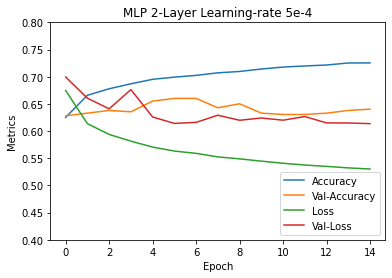

In [19]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val-Accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val-Loss')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0.4, 0.8])
plt.legend(loc='lower right')
plt.title('MLP 2-Layer Learning-rate 5e-4')

In [20]:
test_loss, test_sparse_entropy, test_acc = model.evaluate(test_img_ds,  verbose=2)
print(test_acc)

1/1 - 0s - loss: 0.9274 - Sparse_CategoricalCrossentropy: 0.9274 - accuracy: 0.6444 - 111ms/epoch - 111ms/step
0.644444465637207


In [21]:
test_loss, test_sparse_entropy, test_acc = model.evaluate(norm_test_img_ds,  verbose=2)
print(test_acc)

1/1 - 0s - loss: 0.4880 - Sparse_CategoricalCrossentropy: 0.4880 - accuracy: 0.8000 - 94ms/epoch - 94ms/step
0.800000011920929
